In [1]:
# Notebook inspired by the models shared:
# Link: https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling
# Link: https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50/notebook

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Better rendering 
from IPython.core.display import HTML
HTML("<style>.rendered_html th {max-width: 120px;}</style>")

warnings.filterwarnings('ignore')

# settings to display all columns
pd.set_option("display.max_columns", None)

In [4]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

---

### 1. Fetch Data and Processing
#### Import Data

In [16]:
# Sales Data: Training Set (1-1913) + Validation Set (1914-1941)
sales = pd.read_csv('Data/sales_train_evaluation.csv')
sales.name = 'sales'

print("{:,} records for training data".format(len(sales)))

# Calendar
calendar = pd.read_csv('Data/calendar.csv')
calendar.name = 'calendar'
print("{:,} records for calendar data".format(len(calendar)))

# Pricing
prices = pd.read_csv('Data/sells_prices_improved.csv')
prices.name = 'prices'
print("{:,} records for price data".format(len(prices)))

30,490 records for training data
1,969 records for calendar data
6,841,121 records for price data


#### Add records for testing

In [12]:
# Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

#### Downcasting to reduce memory
Source: https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling
> Shout out to him, it's very useful!

In [13]:
# Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        # Integer
        if 'int' in str(t):
            # Check if minimum and maximum are in the limit of int8
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            # Check if minimum and maximum are in the limit of int16
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            # Check if minimum and maximum are in the limit of int32
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            # Choose int64
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        # Float
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        # Object
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

# # Apply downcasting
sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

### Additional Features: Pricing
- Relative difference between the current price of an item and its historical average price, to highlight promotional offers’ impact.
- Price relative difference with the same item sold in other stores, to understand whether or not the store has an attractive price.
- Price relative difference with other items sold in the same store and same product category, to capture some cannibalization effects.

In [14]:
def improve_price():
    # Calculate Average price for all stores
    df_mean_store = pd.DataFrame(prices.groupby(['item_id', 'wm_yr_wk'])['sell_price'].mean())
    df_mean_store.columns = ['item_sells_price_avg']
    df_mean_store.reset_index(inplace = True)

    # Combine with calendar
    prices_new = pd.merge(prices, df_mean_store, on=['item_id', 'wm_yr_wk'], how='left', suffixes=('', '_y'))
    prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    # Price difference with same items in other stores
    prices_new['delta_price_all_rel'] = (prices_new['sell_price'] - 
                                         prices_new['item_sells_price_avg'])/prices_new['item_sells_price_avg']

    # Price difference with last week
    prices_new['item_store'] = prices_new['item_id'].astype(str) + '_' + prices_new['store_id'].astype(str)
    prices_new['item_store_change'] = prices_new["item_store"].shift() != prices_new["item_store"]
    # Price difference week n - week n-1
    prices_new['delta_price_weekn-1'] = (prices_new['sell_price']-
                                         prices_new['sell_price'].shift(1)).fillna(0)/prices_new['sell_price'].shift(1)
    prices_new['delta_price_weekn-1'] = prices_new['delta_price_weekn-1'].fillna(0) * (prices_new['item_store_change']==0)

    # Average price of the department by store
    prices_new['dept_id'] = prices_new.item_id.str[:-4]
    df_mean_cat = pd.DataFrame(prices_new.groupby(['dept_id', 'store_id', 'wm_yr_wk'])['sell_price'].mean())
    df_mean_cat.columns = ['dept_sells_price_avg']
    df_mean_cat.reset_index(inplace = True)
    # Combine with price dataset
    prices_new = pd.merge(prices_new, df_mean_cat, on=['dept_id', 'store_id', 'wm_yr_wk']
                          , how='left', suffixes=('', '_y'))
    prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    # Cannibalisation: compare this item price with average of the department (category)
    prices_new['delta_price_cat_rel'] = (prices_new['sell_price'] - 
                                         prices_new['dept_sells_price_avg'])/prices_new['dept_sells_price_avg']                                               

    # Drop columns
    prices_new.drop(['item_sells_price_avg', 'item_store_change', 'item_store_change', 'dept_id', 'item_store',
                    'dept_sells_price_avg'], axis = 1, inplace = True)

### 2. Melt Data to reconstitute sales records
#### Convert from wide to long format (records on row level)

In [15]:
# Melt
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
             var_name='d', value_name='sold').dropna()
print("{:,} records to combine with calendar and price".format(len(df)))
df.head()

60,034,810 records to combine with calendar and price


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


#### Combine Data

In [16]:
# Combine with calendar
df = pd.merge(df, calendar, on='d', how='left')
# Combine with price
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [17]:
print("{:,} records in df".format(len(df)))
df.head()

60,034,810 records in df


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Unnamed: 0,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN


In [18]:
del sales

---

## Features Engineering
> Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms:
- There is no concept of input and output features in time series. 
- Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

### 1. Label Encoding

In [19]:
# Change Store id to category type
df.store_id = df.store_id.astype('category')
df.item_id = df.item_id.astype('category')
df.cat_id = df.cat_id.astype('category')
df.state_id = df.state_id.astype('category')
df.id = df.id.astype('category')
df.dept_id = df.dept_id.astype('category')

# Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))

# Item, Department and Categories
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))

# Stores and States
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

# Save to DataFrame
LIST_SAVE = [d_id, d_item_id, d_dept_id, d_cat_id, d_store_id, d_state_id]
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
for list_save, list_name in zip(LIST_SAVE, LIST_NAME):
    pickle.dump(list_save, open('Data/General/{}.p'.format(list_name), "wb"))  

In [20]:
# Mapping with Category Codes

# Remove d_ and transform to int (dates)
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()

# Transform categorical data to codes
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
# Drop Dates
df.drop('date',axis=1,inplace=True)
print("Dataframe shape: {}".format(df.shape))
df.head()

Dataframe shape: (60034810, 25)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Unnamed: 0,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN


### 2. Introduce Lag
> Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.
- Introduce lags to the the target variable sold. 
- The maximum lag I have introduced is 36 days. 
- It's purely upto you how many lags you want to introduce.

> TODO LIST: Test performances and features importance with other values of lags

In [21]:
# Introduce lags (days)
lags = [1, 2, 3, 7, 14, 28]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(
        ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
        as_index = False)['sold'].shift(lag).astype(np.float16)
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Unnamed: 0,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

### 3. Mean Encoding
> From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value. I have calculated mean encodings on the basis of following logical features

- item
- state
- store
- category
- department
- category & department
- store & item
- category & item
- department & item
- state & store
- state, store and category
- store, category and department

In [22]:
# Total Average Sales by: item, state, store, cat and dept
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)

# Sales average by 
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

### 4. Rolling Average (Window) on actual sales
| Days = 7

In [23]:
df['rolling_sold_mean'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
    lambda x: x.rolling(window=7).mean()).astype(np.float16)

# Average for the last n days
for days in [3, 7, 14, 21, 28]:
    df['rolling_sold_mean_{}'.format(days)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
    lambda x: x.rolling(window=days).mean()).astype(np.float16)

### 5. Rolling Average (Window) on actual lag
- rmean_7_7: rolling mean sales of a window size of 7 over column lag_7
- rmean_7_28: rolling mean sales of a window size of 7 over column lag_28
- rmean_28_7: rolling mean sales of a window size of 28 over column lag_7
- rmean_28_28: rolling mean sales of a window size of 28 over column lag_28

In [24]:
# Rolling Average on actual lag
for window, lag in zip([7, 7, 28, 28], [7, 28, 7, 28]):
    df['rolling_lag_{}_win_{}'.format(window, lag)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold_lag_{}'.format(lag)].transform(
    lambda x: x.rolling(window=window).mean()).astype(np.float16)

### 6. Trends 
By SKU (Store + Item Id)

In [25]:
# Daily Average by SKU (Item Id + Store)
df['daily_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
# Total Average by SKU (Item Id + Store)
df['avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
# Selling Trend
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)

# Drop Columns 
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

---

## /!\ Additional Ideas for Features Engineering /!\ 
### Trends by SKU for all stores
By Item (All Stores)

In [26]:
# Daily Average by SKU (Item Id + Store)
df['item_daily_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'd'])['sold'].transform('mean').astype(np.float16)
# Total Average by SKU (Item Id + Store)
df['item_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id'])['sold'].transform('mean').astype(np.float16)
# Selling Trend
df['item_selling_trend'] = (df['item_daily_avg_sold'] - df['item_avg_sold']).astype(np.float16)

# Drop Columns 
df.drop(['item_daily_avg_sold','item_avg_sold'],axis=1,inplace=True)

### Rolling Average (Window) on actual lag
- rmean_7_7: rolling mean sales of a window size of 7 over column lag_7
- rmean_7_28: rolling mean sales of a window size of 7 over column lag_28
- rmean_28_7: rolling mean sales of a window size of 28 over column lag_7
- rmean_28_28: rolling mean sales of a window size of 28 over column lag_28

Insipiration: https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50/notebook
> Great explanation in comments based on business insights (why 7, 28 days?)

In [27]:
# Rolling Average on actual lag
for window, lag in zip([7, 7, 28, 28], [7, 28, 7, 28]):
    df['rolling_lag_{}_win_{}'.format(window, lag)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold_lag_{}'.format(lag)].transform(
    lambda x: x.rolling(window=window).mean()).astype(np.float16)

### Rolling Max (Window): Last n days

In [28]:
df['rolling_sold_max'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
    lambda x: x.rolling(window=7).max()).astype(np.float16)

# Average for the last n days
for days in [1, 2, 7, 14, 21, 28]:
    df['rolling_sold_max_{}'.format(days)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
    lambda x: x.rolling(window=days).max()).astype(np.float16)

### Stock-Outs: Do you have stock availability issue that cause zero sales in the last n days ?

Definition: 
- When the inventory level is below the customer demand we have a stock-out (i.e if you have 0 units in your shelves and customer are looking for your products => stock-out)

> Assumption: we will suppose that if you do not have sales for 3 days in a row you have a stock-out

In [29]:
# Sort the dataset by item_id and day
df.sort_values(['id', 'd'], ascending =[True, True], inplace = True)

# Mapping id change
df['id_change'] = df['id'].diff().fillna(0)
print("{:,} unique id with {:,} id changes".format(df.id.nunique(), df['id_change'].sum()))
# Zero Sale 
df['zero_sale'] = (df['sold'] == 0) * (df['id_change']==False) * 1
df['stock_out_id'] = (df['zero_sale'].transform(
        lambda x: x.rolling(window=3).sum()).astype(np.float16)==3) * 1

# Drop useless columns
df.drop(['id_change', 'zero_sale'], axis = 1, inplace = True)

# Stock-Outs in the last n days ?
for n_days in [1, 2, 7]: 
    df['stock_out_id_last_{}_days'.format(n_days)] = (df['stock_out_id'].transform(
        lambda x: x.rolling(window=n_days).sum()).astype(np.float16)>0) * 1

30,490 unique id with 30,489.0 id changes


### Store Opening: Was the store closed in the last n days ?

> Assumption: if the store total sales is zero => closed

In [30]:
# Store Closed = Sales zero
df['store_closed'] = (df.groupby(
    ['store_id', 'd'])['sold'].transform('sum').astype(np.float16) == 0) * 1

In [31]:
# Store Closed = Sales zero
for n_days in [1, 2, 7]: # closed the last week 
    df['store_closed_last_{}_days'.format(n_days)] = (df['store_closed'].transform(
        lambda x: x.rolling(window=n_days).sum()).astype(np.float16)>0) * 1

### Save Dataset

In [33]:
df.to_pickle('Data/data_features_improved.pkl')

In [34]:
del df

---

## Modelling and Prediction
> Model = LGBM
- Choose features (original + additional)
- TO DO Search Grid (I can't because of my limited computing ressources :))
- Measure Performance

#### Import Procesed DataFrame

In [5]:
# Import Data
data_size = 'improved'
data = pd.read_pickle('Data/data_features_{}.pkl'.format(data_size))

# Start records from 55th
start_row = 55
data = data[data['d'] >= start_row].copy()
print("{:,} records for the prepared data".format(len(data)))
data.head()

58,388,350 records for the prepared data


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Unnamed: 0,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,rolling_sold_mean_3,rolling_sold_mean_7,rolling_sold_mean_14,rolling_sold_mean_21,rolling_sold_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,selling_trend,item_selling_trend,rolling_sold_max,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days,store_closed,store_closed_last_1_days,store_closed_last_2_days,store_closed_last_7_days
1648072,0,0,0,0,0,0,55,0,11108,4,6,3,2011,-1,-1,-1,-1,0,0,0,368753.0,2.0,0.0,0.0,-0.322754,1.0,1.0,1.0,0.0,3.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,0.714355,0.666504,0.714355,0.856934,1.142578,1.500000,1.000000,1.571289,1.713867,NaN,-0.774902,-0.774902,1.0,0.0,1.0,1.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1678562,0,0,0,0,0,0,56,1,11108,0,7,3,2011,-1,-1,-1,-1,0,0,0,368753.0,2.0,0.0,0.0,-0.322754,0.0,1.0,1.0,0.0,0.0,4.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,0.856934,0.666504,0.856934,0.928711,1.142578,1.392578,1.000000,1.857422,1.642578,1.392578,0.225098,0.225098,1.0,1.0,1.0,1.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1709052,0,0,0,0,0,0,57,2,11109,2,1,3,2011,-1,-1,-1,-1,0,0,0,368754.0,2.0,0.0,0.0,-0.322754,1.0,0.0,1.0,1.0,1.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.000000,1.000000,1.000000,1.000000,1.142578,1.392578,1.000000,2.000000,1.642578,1.357422,1.224609,1.224609,2.0,2.0,2.0,2.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1739542,0,0,0,0,0,0,58,2,11109,3,2,3,2011,-1,-1,-1,-1,0,0,0,368754.0,2.0,0.0,0.0,-0.322754,2.0,1.0,0.0,1.0,5.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.142578,1.666992,1.142578,0.785645,1.095703,1.392578,0.428467,2.000000,1.607422,1.428711,1.224609,1.224609,2.0,2.0,2.0,2.0,2.0,5.0,7.0,0,0,0,0,0,0,0,0
1770032,0,0,0,0,0,0,59,0,11109,1,3,3,2011,-1,-1,-1,-1,0,0,0,368754.0,2.0,0.0,0.0,-0.322754,2.0,2.0,1.0,1.0,0.0,0.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.000000,1.333008,1.000000,0.785645,1.095703,1.392578,0.571289,2.000000,1.642578,1.428711,-0.774902,-0.774902,2.0,0.0,2.0,2.0,2.0,5.0,7.0,0,0,0,0,0,0,0,0


#### Import key data

In [7]:
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
dict_data = {}
for list_name in LIST_NAME:
    dict_temp = pickle.load(open('Data/General/{}.p'.format(list_name), "rb"))
    dict_data[list_name] = dict_temp
    del dict_temp

### 1. Show Features
> We'll split the features we created in groups so we can add them progressively and measure the impact on the accuracy

In [8]:
# Initial Features
INIT_FEAT = list(data.columns[0:21])

# Lags and averages
LAGAV_FEAT = list(data.columns[24:42])

# Rolling Means and Rolling Means on lag
ROLLMEAN_FEAT = list(data.columns[42:52])

# Trends and Rolling MAX
TREND_MAX_FEAT = list(data.columns[52:58])

# Stock-Out and Store Closed
# SO_CLOSED_FEAT = list(data.columns[58:67])
SO_CLOSED_FEAT = list(['stock_out_id', 'store_closed'])

# PRICE COMPARISON
PRICE_COMPARE = list(data.columns[21:24])

# Dictionnary with different steps
dict_features = {
    'STEP_1': INIT_FEAT,
    'STEP_2': INIT_FEAT+LAGAV_FEAT,
    'STEP_3': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT,
    'STEP_4': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT,
    'STEP_5': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT+SO_CLOSED_FEAT,
    'STEP_6': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT+SO_CLOSED_FEAT+PRICE_COMPARE,
}
LIST_STEPS = ['STEP_1', 'STEP_2', 'STEP_3', 'STEP_4', 'STEP_5', 'STEP_6']
LIST_STEPS_NAME = ['INITIAL_DATA', 'INITIAL + LAG + AVERAGES', 
                  'INITIAL + LAG + AVERAGES + ROLLING MEAN',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED + PRICE COMPARISON']
dict_stepname = dict(zip(LIST_STEPS, LIST_STEPS_NAME))

### 2. Train and Test Models
#### Create Validation and Test sets

In [11]:
# Validation Set
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
# Validation Prediction
valid_preds = valid['sold']

# Test Set
test = data[data['d'] >= 1942][['id', 'd', 'sold']]
# Evaluation Prediction
eval_preds = test['sold']

#### Train and Test Models with different features

In [12]:
# Get the store ids
stores = data.store_id.unique()
d_store_id = dict_data['d_store_id']

# Dictionnary with errors each step
dict_error = {}

# Loop with the steps
for step in LIST_STEPS:

    # Folder for Models 
    print('*****Prediction for STEP: {}*****'.format(dict_stepname[step]))
    FOLDER_MODEL = 'Model/{}/{}_Features_Improved/'.format(data_size, step)
    Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)
    COLS_SCOPE = dict_features[step]

    # DataFrame with filter scope
    data_scope = data[COLS_SCOPE].copy()

    # Validation Set
    valid = data_scope[(data_scope['d']>=1914) & (data_scope['d']<1942)][['id','d','sold']]
    # Validation Prediction
    valid_set = valid['sold']

    # Validation + Predicition for all stores by step 
    df_validpred = pd.DataFrame()

    # Loop for training a model for each store
    for store in stores:

        # Dataframe for each store
        df = data_scope[data_scope['store_id']==store]

        # Train Data until day = 1914
        X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']

        # Validation Day: 1914 to 1942
        X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']

        # X_test with 
        X_test = df[df['d']>=1942].drop('sold',axis=1)
        
        # Train and validate
        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )


        # Fit model
        model.fit(X_train, y_train, 
                  eval_set = [(X_train,y_train),(X_valid,y_valid)], 
                  eval_metric = 'rmse', 
                  verbose = 0, 
                  early_stopping_rounds = 20)

        # Compute Prediction
        valid_pred = model.predict(X_valid)

        # Actual Validation vs. Prediction
        df_valid = pd.DataFrame({
            'validation':valid_set[X_valid.index],
            'prediction':valid_pred,
            'store': d_store_id[store]
        })
        df_valid['error'] = df_valid['validation'] - df_valid['prediction']
        df_validpred = pd.concat([df_validpred, df_valid])
        # Save prediction
        df_valid.to_csv(FOLDER_MODEL + 'prediction_{}.csv'.format(step))

        # Save model
        filename = FOLDER_MODEL + 'model_features_total-' + str(d_store_id[store])+'.pkl'
        joblib.dump(model, filename)

        del model, X_train, y_train, X_valid, y_valid

    # Save Prediction for all stores
    df_validpred.to_csv(FOLDER_MODEL + 'prediction_{}.csv'.format(step))

    # Compute Error
    valid_rmse = 100 * np.sqrt(np.mean((df_validpred.validation.values - df_validpred.prediction.values) ** 2))/np.mean(df_validpred.validation.values)
    # Add Error in a Dictionnary
    dict_error[step] = valid_rmse
    print("For {}: RMSE = {}".format(dict_stepname[step], valid_rmse))

# Final DataFrame with error for all stores by STEP
df_error = pd.DataFrame({
    'STEP': LIST_STEPS,
    'STEP_NAME': [dict_stepname[step] for step in LIST_STEPS],
    'rmse': [dict_error[step] for step in LIST_STEPS]
    })
df_error.to_excel(FOLDER_MODEL + 'df_error.xlsx')
df_error

*****Prediction for STEP: INITIAL_DATA*****
For INITIAL_DATA: RMSE = 166.5922878247231
*****Prediction for STEP: INITIAL + LAG + AVERAGES*****
For INITIAL + LAG + AVERAGES: RMSE = 136.86106334740734
*****Prediction for STEP: INITIAL + LAG + AVERAGES + ROLLING MEAN*****
For INITIAL + LAG + AVERAGES + ROLLING MEAN: RMSE = 18.613120309842593
*****Prediction for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX*****
For INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX: RMSE = 6.47061859337155
*****Prediction for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED*****
For INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED: RMSE = 6.355151609638661
*****Prediction for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED + PRICE COMPARISON*****
For INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX +

,STEP,STEP_NAME,rmse
0,STEP_1,INITIAL_DATA,166.592288
1,STEP_2,INITIAL + LAG + AVERAGES,136.861063
2,STEP_3,INITIAL + LAG + AVERAGES + ROLLING MEAN,18.613120
3,STEP_4,INITIAL + LAG AND AVERAGES + ROLLING MEAN + TR...,6.470619
4,STEP_5,INITIAL + LAG AND AVERAGES + ROLLING MEAN + TR...,6.355152
5,STEP_6,INITIAL + LAG AND AVERAGES + ROLLING MEAN + TR...,4.598721


### Plot 

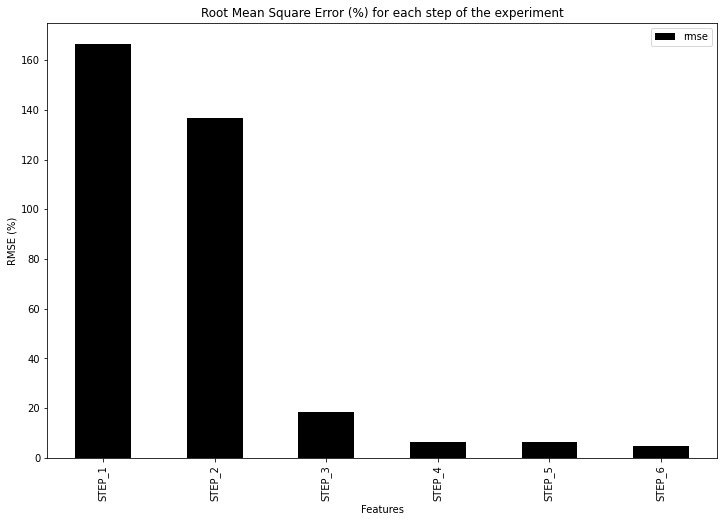

In [20]:
# Plot
ax = plt.gca()
df_error.plot.bar(figsize=(12, 8), x='STEP', y='rmse', ax=ax, color = 'black')
plt.xlabel('Features')
plt.ylabel('RMSE (%)')
plt.title('Root Mean Square Error (%) for each step of the experiment')
plt.xticks(rotation=90)
plt.show()

---

## Additional Analysis
### Plot Features Importance for each model

*****Prot Features Importance for STEP: INITIAL_DATA*****


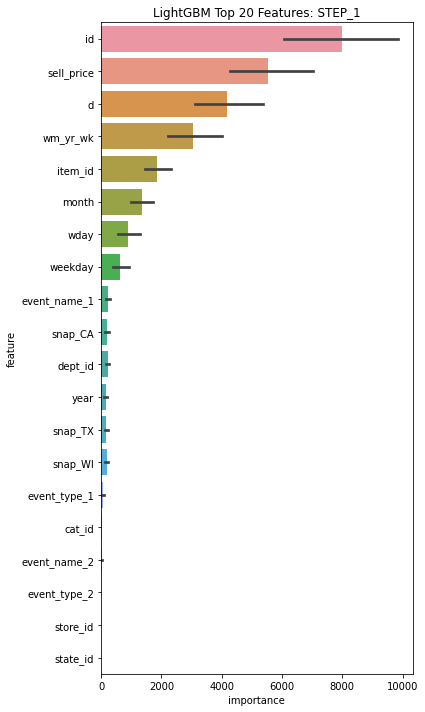

*****Prot Features Importance for STEP: INITIAL + LAG + AVERAGES*****


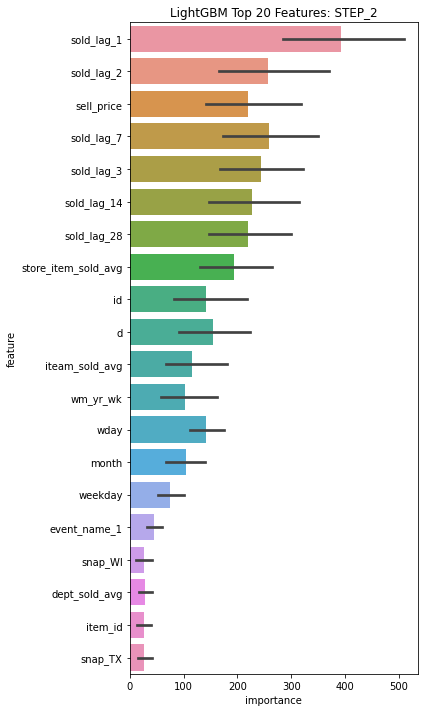

*****Prot Features Importance for STEP: INITIAL + LAG + AVERAGES + ROLLING MEAN*****


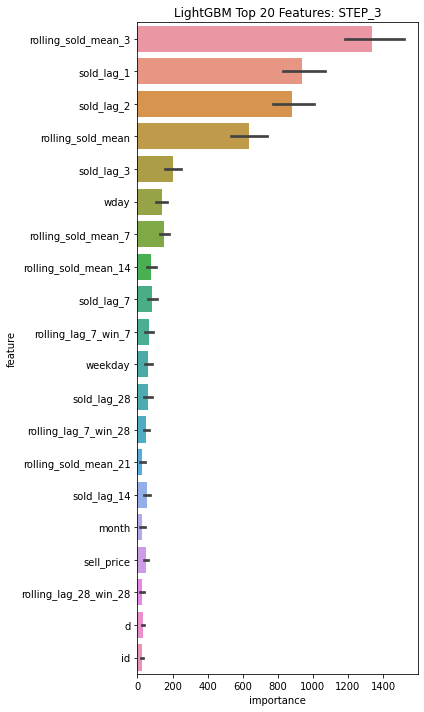

*****Prot Features Importance for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX*****


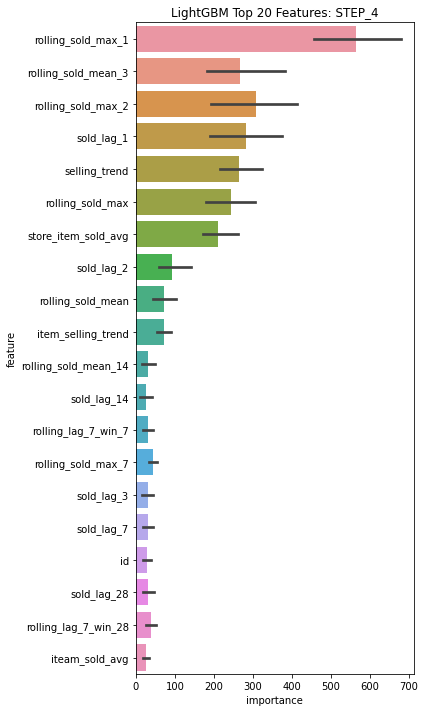

*****Prot Features Importance for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED*****


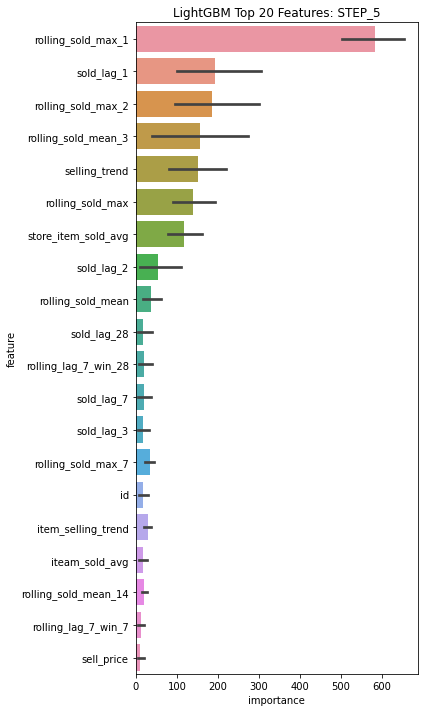

*****Prot Features Importance for STEP: INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED + PRICE COMPARISON*****


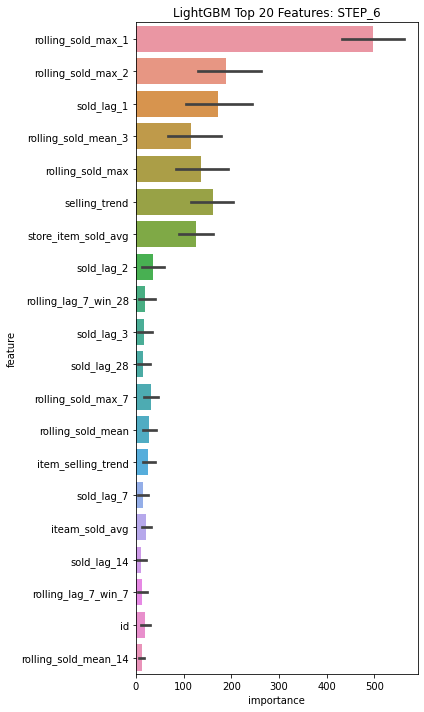

In [24]:
# Folder for Models 
for step in LIST_STEPS:
    print('*****Prot Features Importance for STEP: {}*****'.format(dict_stepname[step]))

    FOLDER_MODEL = 'Model/{}/{}_Features_Improved/'.format(data_size, step)
    Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)
    COLS_SCOPE = dict_features[step]

    feature_importance_df = pd.DataFrame()
    features = [f for f in COLS_SCOPE if f != 'sold']

    for store in stores:
        store_name = d_store_id[store]
        filename = FOLDER_MODEL + 'model_features_total-' + str(d_store_id[store])+'.pkl'
        # load model
        model = joblib.load(filename)

        # Create features importance for this model
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = store_name

        # Concat
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)

    # Features Importances Analysis
    df_fi_mean = pd.DataFrame(feature_importance_df[
        ["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False))
    df_fi_mean.columns = ['importance']
    df_fi_mean['%_importance'] = (100 * df_fi_mean['importance']/df_fi_mean['importance'].sum(axis =0)).round(2)
    df_fi_mean.to_excel(FOLDER_MODEL + 'Features_Importance_{}.xlsx'.format(step))


    # Plot
    cols = df_fi_mean[:20].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    fig = plt.figure(figsize=(6,10))
    ax = fig.gca()
    sns.barplot(x="importance", y="feature", data = best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Top 20 Features: {}'.format(step))
    plt.tight_layout()
    fig.savefig(FOLDER_MODEL + 'Features_Importance_{}.png'.format(step))
    plt.show()